[![](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/ArashAkbarinia/mbb/blob/main/notebooks/linear_classifier_probe.ipynb)

# Probing intermediate layers by linear classifiers,

This tutorial showcases how to use linear classifiers to interpret the representation encoded in different layers of a deep neural network. We study that in pretrained networks trained on ImageNet.

There are several techniques that we can exercise to learn about the representation a network has learnt during its training:
* [lesioning](https://colab.research.google.com/github/ArashAkbarinia/mbb/blob/main/notebooks/lesion.ipynb) individual or ensemble of kernels,
* recording [activation maps](https://colab.research.google.com/github/ArashAkbarinia/mbb/blob/main/notebooks/activation.ipynb) individual or ensemble of kernels,
* probing intermediate layers by linear classifiers (**this notebook**).

Ton assess whether a certain feature is encoded in the representation learnt by a network, we can check its discrimination power for that said feature. We cannot directly ask the pretrained network about the feature of interest, therefore we interpret the learnt representation using a linear classifier. We extract features from a frozen pretrained network, and only the weights of the linear classifier are optimised during the training.

<img src="https://www.dropbox.com/s/gbzkp0y8x24jrk2/csf_pipeline.png?dl=1">

In this technique:
* We can extract features at any layer.
* Often the extracted features have a large dimensionality because of the spatial resolution, one can reduce this by adaptive pooling mechanism without learning any parameters.
* We must make sure, the obtained results are not due to (or biased by) the training procedure of the linear classifier.

Example articles that use this technique:
* [Understanding intermediate layers using linear classifier probes](https://arxiv.org/abs/1610.01644)
* [Contrast Sensitivity Function in Deep Networks](https://www.biorxiv.org/content/10.1101/2023.01.06.523034v2.abstract)

# 0. Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main package for scientific computing with Python. It's often imported with the `np` shortcut.
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [os](https://docs.python.org/3/library/os.html) provides a portable way of using operating system-dependent functionality, e.g., modifying files/folders.
 * [cv2](https://docs.opencv.org/4.x/index.html) is a leading computer vision library.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.

In [1]:
# importing the necessary packages/libraries
import numpy as np
from matplotlib import pyplot as plt
import random
import os

import cv2

import torch
import torchvision
from torchvision import models
import torchvision.transforms as torch_transforms

## device
Choosing CPU or GPU based on the availability of the hardware.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Stimuli

We study contrast.

## Train dataset

In [4]:
labels_map = {
    0: "circle",
    1: "ellipse",
    2: "rectangle"
}

def create_random_shape(img_size):
    """This functions generates geometrical shapes on top of a background image."""
    # choosing a colour for the shape, there is a slim chance of being identical to the background,
    # we can consider this the noise in our dataset!
    img = np.zeros((img_size, img_size, 3), dtype='uint8') + 128
    
    colour = [random.randint(0, 255) for _ in range(3)]
    point1 = np.random.randint(img.shape[0] // 4, 3 * (img.shape[0] // 4), 2)
    
    # drawing a random geomterical shape
    shape_ind = np.random.randint(0, len(labels_map))
    # when the tickness is negative, the shape is drawn filled
    thickness = -1
    
    if shape_ind == 0: # circle
        radius = np.random.randint(10, img.shape[0] // 4)
        img = cv2.circle(img, point1, radius, color=colour, thickness=thickness)
    elif shape_ind == 1: # ellipse
        axes = [
            np.random.randint(10, 20),
            np.random.randint(30, img.shape[0] // 4)
        ]
        angle = np.random.randint(0, 360)
        img = cv2.ellipse(img, point1, axes, angle, 0, 360, color=colour, thickness=thickness)
    else: # rectangle
        point2 = np.random.randint(0, img.shape[0], 2)
        img = cv2.rectangle(img, point1, point2, color=colour, thickness=thickness)
    return img, shape_ind


def _adjust_contrast(image, amount):
    return (1 - amount) / 2.0 + np.multiply(image, amount)


class ContrastDataset(torch.utils.data.Dataset):

    def __init__(self, num_imgs, target_size, transform=None):
        """
        Parameters:
        ----------
        num_imgs : int
            The number of samples in the dataset.
        target_size : int
            The spatial resolution of generated images.  
        transform : List, optional
            The list of transformation functions,
        """
        self.num_imgs = num_imgs
        self.target_size = target_size
        self.transform = transform

    def __len__(self):
        return self.num_imgs

    def __getitem__(self, _idx):
        # our routine doesn't need the idx, which is the sample number
        img1, _ = create_random_shape(self.target_size)
        # we make two images, one with high-contrast and another with low-contrast
        img1 = img1.astype('float32') / 255
        img2 = img1.copy()

        contrasts = np.random.uniform(0, 1, 2)
        # network's task is to find which image has a higher contrast
        gt = np.argmax(contrasts)

        img1 = _adjust_contrast(img1, contrasts[0])
        img2 = _adjust_contrast(img1, contrasts[1])

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1.float(), img2.float(), gt

## Torch Tensors

Before inputting a network with our images we **normalise** them to the range of values that the pretrained network was trained on.

While this step is not strictly speaking mandatory, it's sensible to measure the response of kernels under similar conditions that the network is meant to function.

In the end, we visualise the tensor images (after inverting the normalisation). This is often a good exercise to do to ensure what we show to networks is correct.

In [5]:
# the training size of ImageNet pretrained networks
target_size = 224
# mean and std values of ImageNet pretrained networks
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# the list of transformation functions
transform = torch_transforms.Compose([
    torch_transforms.ToTensor(),
    torch_transforms.Normalize(mean=mean, std=std)
])

num_imgs = 1000
train_db = ContrastDataset(num_imgs, target_size, transform)

batch_size = 16
train_loader = torch.utils.data.DataLoader(
    train_db, batch_size=batch_size, shuffle=True,
    num_workers=0, pin_memory=True, sampler=None
)

## Visualise samples

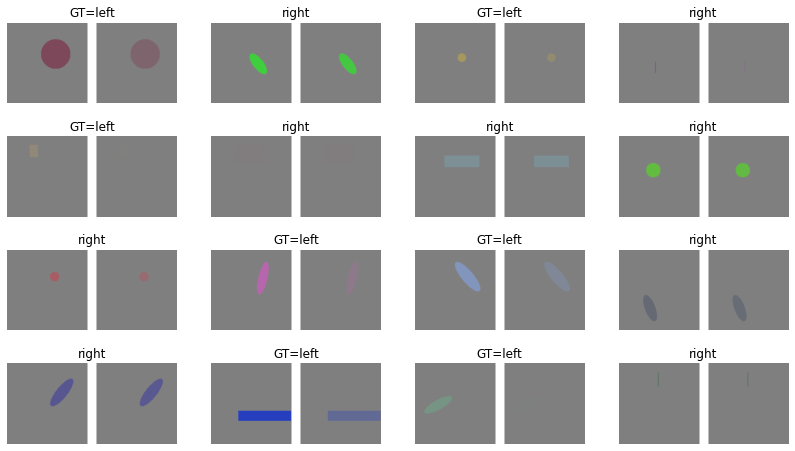

In [6]:
fig = plt.figure(figsize=(14, 8))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    img_i1, img_i2, gt_i = train_db.__getitem__(i)
    # image should be detached from gradient and converted to numpy "detach().cpu().numpy()"
    # the axis should change to <width, height, channel> "transpose(1, 2, 0)"
    # the normalisation should be inverted for visualisation purposes "* std + mean"
    img_i1 = img_i1.detach().cpu().numpy().transpose(1, 2, 0) * std + mean
    img_i2 = img_i2.detach().cpu().numpy().transpose(1, 2, 0) * std + mean
    img_i = np.concatenate([img_i1, np.ones((target_size, 25, 3)), img_i2], axis=1)
    ax.imshow(img_i)
    ax.axis('off')
    ax.set_title('GT=%s' % 'left' if gt_i == 0 else 'right')

## Test dataset

We opted for the contrast detection task similar to the ModelFest dataset, aiming to measure the networks' contrast sensitivity function (CSF) as closely as possible to human psychophysics. Each trial consisted of two intervals, where one interval showed an image with a non-zero contrast modulated sinusoidal gratings, and the other showed an image of the uniform grey background of $0\%$ contrast.

During testing at each trial, we make a new instance of our `GratingsDataset`, each time increasing/decreasing the contrast levels passed to the initialiser depending on the performance of the network. In other words, the sinusoidal grating contrast is adjusted with a staircase procedure until the network reached $75\%$ correct - the same threshold typically assumed in human experiments.

In [28]:
def sinusoid_grating(img_size, amp, omega, rho, lambda_wave):
    if type(img_size) not in [list, tuple]:
        img_size = (img_size, img_size)
    # Generate Sinusoid grating
    # sz: size of generated image (width, height)
    radius = (int(img_size[0] / 2.0), int(img_size[1] / 2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0] + 1), range(-radius[1], radius[1] + 1))

    stimuli = amp * np.cos((omega[0] * x + omega[1] * y) / lambda_wave + rho)
    return stimuli

class GratingsDataset(torch.utils.data.Dataset):

    def __init__(self, target_size, contrasts, sf, transform=None):
        """
        Parameters:
        ----------
        target_size : int
            The spatial resolution of generated images.  
        transform : List, optional
            The list of transformation functions,
        """
        self.target_size = target_size
        self.transform = transform
        self.contrasts = contrasts
        self.sf = sf
        self.thetas = np.arange(0, np.pi + 1e-3, np.pi / 12)

    def __len__(self):
        return len(self.thetas)

    def __getitem__(self, idx):
        theta = self.thetas[idx]
        omega = [np.cos(theta), np.sin(theta)]
        lambda_wave = (self.target_size * 0.5) / (np.pi * sf)
        # generating the gratings
        sinusoid_param = {
            'amp': self.contrasts[0], 'omega': omega, 'rho': 0,
            'img_size': self.target_size, 'lambda_wave': lambda_wave
        }
        img1 = sinusoid_grating(**sinusoid_param)
        sinusoid_param['amp'] = self.contrasts[1]
        img2 = sinusoid_grating(**sinusoid_param)

        # if target size is even, the generated stimuli is 1 pixel larger.
        if np.mod(self.target_size, 2) == 0:
            img1 = img1[:-1, :-1]
            img2 = img2[:-1, :-1]

        # bringing the image in the range of 0-1
        img1 = (img1 + 1) / 2
        img2 = (img2 + 1) / 2
            
        # converting it to 3 channel
        img1 = np.repeat(img1[:, :, np.newaxis], 3, axis=2)
        img2 = np.repeat(img2[:, :, np.newaxis], 3, axis=2)
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        gt = np.argmax(contrasts)
        return img1.float(), img2.float(), gt

In [55]:
contrasts = [1.0, 0.]
sf = 8
test_db = GratingsDataset(target_size, transform=transform, contrasts=contrasts, sf=sf)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

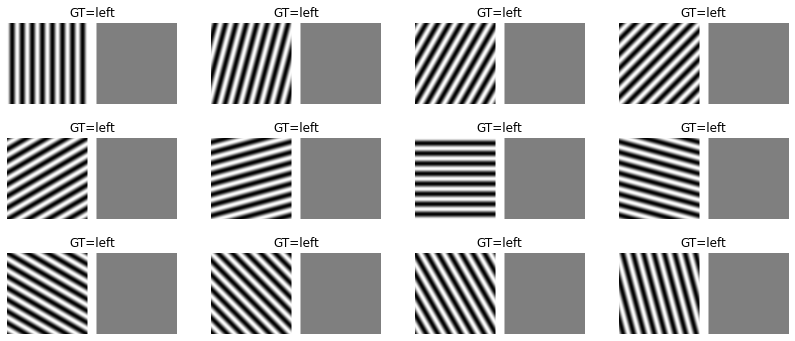

In [56]:
fig = plt.figure(figsize=(14, 6))
for i in range(12):
    ax = fig.add_subplot(3, 4, i+1)
    img_i1, img_i2, gt_i = test_db.__getitem__(i)
    # image should be detached from gradient and converted to numpy "detach().cpu().numpy()"
    # the axis should change to <width, height, channel> "transpose(1, 2, 0)"
    # the normalisation should be inverted for visualisation purposes "* std + mean"
    img_i1 = img_i1.detach().cpu().numpy().transpose(1, 2, 0) * std + mean
    img_i2 = img_i2.detach().cpu().numpy().transpose(1, 2, 0) * std + mean
    img_i = np.concatenate([img_i1, np.ones((target_size, 25, 3)), img_i2], axis=1)
    ax.imshow(img_i)
    ax.axis('off')
    ax.set_title('GT=%s' % 'left' if gt_i == 0 else 'right')

# 2. Network

The structure of our network is quite similar to [transfer learning](https://colab.research.google.com/github/ArashAkbarinia/mbb/blob/main/notebooks/vision.ipynb) we saw in an earlier class. The main difference is that:
* in `LinearProbe` the `forward` function receives two images,
* it extracts features from the pretrained network for each image independently,
* it concatenates the extract features and inputs it to the linear classifier that perform a 2AFC. 

In [11]:
class LinearProbe(torch.nn.Module):
    def __init__(self, pretrained=None):
        super(LinearProbe, self).__init__()

        if pretrained is None:
            pretrained = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
            pretrained = torch.nn.Sequential(*list(pretrained.children())[:5])

        self.feature_extractor = pretrained
        for p in self.feature_extractor.parameters():
            p.requires_grad = False

        self.pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        feature_size = 256
        self.fc = torch.nn.Linear(2 * feature_size, 1)

    def forward(self, x1, x2):
        x1 = self.feature_extractor(x1)
        x1 = self.pool(x1)
        x1 = torch.flatten(x1, start_dim=1)
        
        x2 = self.feature_extractor(x2)
        x2 = self.pool(x2)
        x2 = torch.flatten(x2, start_dim=1)

        x = torch.cat([x1, x2], dim=1)
        return self.fc(x).squeeze()

# 3. Training

In [12]:
def accuracy(output, target):
    """Computes the accuracy."""
    with torch.no_grad():
        pred = output > 0.5
        batch_size = target.size(0)
        correct = pred.eq(target)
        return torch.mean(correct.float())

def epoch_loop(model, db_loader, criterion, optimiser):
    # usually the code for train/test has a large overlap.
    is_train = False if optimiser is None else True

    # model should be in train/eval model accordingly
    model.train() if is_train else model.eval()
    
    accuracies = []
    losses = []
    with torch.set_grad_enabled(is_train):
        for batch_ind, (img1, img2, target) in enumerate(db_loader):
            # moving the image and GT to device
            img1 = img1.to(device)
            img2 = img2.to(device)
            target = target.to(device).float()
            output = model(img1, img2)
            
            # computing the loss function
            loss = criterion(output, target)
            losses.extend([loss.item() for i in range(img1.size(0))])
            # computing the accuracy
            acc = accuracy(output, target).cpu().numpy()
            accuracies.extend([acc for i in range(img1.size(0))])
            
            if is_train:
                # compute gradient and do SGD step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    return accuracies, losses

In [14]:
linear_probe = LinearProbe().to(device)
params_to_optimize = [{'params': [p for p in linear_probe.fc.parameters()]}]
momentum = 0.9
learning_rate = 0.1
weight_decay = 1e-4
optimizer = torch.optim.SGD(
    params_to_optimize, lr=learning_rate,
    momentum=momentum, weight_decay=weight_decay
)

# doing epoch
criterion = torch.nn.BCEWithLogitsLoss().to(device)
epochs = 10
initial_epoch = 0
train_logs = {'acc': [], 'loss': []}
for epoch in range(initial_epoch, epochs):
    train_log = epoch_loop(linear_probe, train_loader, criterion, optimizer)
     
    print('[%.3d] loss=%.4f     acc=%0.2f' % (epoch, np.mean(train_log[1]), np.mean(train_log[0])))
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))

[000] loss=0.7130     acc=0.51
[001] loss=0.6245     acc=0.63
[002] loss=0.6575     acc=0.60
[003] loss=0.6067     acc=0.65
[004] loss=0.5431     acc=0.70
[005] loss=0.5890     acc=0.67
[006] loss=0.5391     acc=0.70
[007] loss=0.5483     acc=0.73
[008] loss=0.5689     acc=0.68
[009] loss=0.5050     acc=0.72


## Loss – accuracy

We're not really interested in the outcome of training, this is just a tool that allows us to do the testing (e.g., psychophysics). Nevertheless, we must ensure that the linear classifier is learning to perform the task.

**Note**: if the linear classifier never learns this task (after different hyper-parameter tuning), we can conclude that our feature of interest (in this example contrast) is not encoded in the representation of the network.

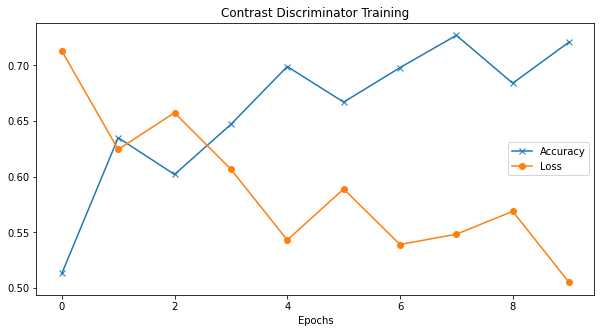

In [18]:
plt.figure(figsize=(10,5))
plt.title("Contrast Discriminator Training")
plt.plot(train_logs['acc'], '-x', label="Accuracy")
plt.plot(train_logs['loss'], '-o', label="Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# 4. Testing

We test the network with a staircase paradigm. At every spatial frequency 

    [1, 2, 4, 7, 8, 14, 16, 28, 32, 56, 112]

We test the network with two images, one with 0% contrast and another with positive contrast. We gradually adjust the level of contrast till networks reach $75%$ accuracy.

In [51]:
def midpoint(acc, low, mid, high, th, ep=1e-4):
    diff_acc = acc - th
    if abs(diff_acc) < ep:
        return None, None, None
    elif diff_acc > 0:
        new_mid = (low + mid) / 2
        return low, new_mid, mid
    else:
        new_mid = (high + mid) / 2
        return mid, new_mid, high

def _sensitivity_sf(model, sf):
    """Computing the psychometric function for given spatial frequency."""
    low = 0
    high = 1
    mid = (low +  high) / 2

    res_sf = []
    attempt_i = 0
    psf = {'acc': [], 'contrast': []}

    # th=0.749 because test samples are 16, 12 correct equals 0.75 and test stops
    th = 0.749
    while True:
        db_loader = torch.utils.data.DataLoader(
            GratingsDataset(target_size, transform=transform, contrasts=[0, mid], sf=sf),
            batch_size=13, shuffle=False, num_workers=0, pin_memory=True, sampler=None
        )

        val_log = epoch_loop(model, db_loader, criterion, None)
        accuracy = np.mean(val_log[0])
        psf['acc'].append(accuracy)
        psf['contrast'].append(int(mid * 1000))
        res_sf.append(np.array([sf, accuracy, mid]))
        new_low, new_mid, new_high = midpoint(accuracy, low, mid, high, th=th)
        if new_mid is None or attempt_i == 20:
            break
        else:
            low, mid, high = new_low, new_mid, new_high
        attempt_i += 1
    return psf, res_sf

In [52]:
# spatial frequencies
sfs = [i for i in range(1, int(target_size / 2) + 1) if target_size % i == 0]

sensitivities = []
for i in range(len(sfs)):
    print('spatial frequency', sfs[i])
    psf_i, res_i = _sensitivity_sf(linear_probe, sfs[i])
    sensitivities.append(1 / res_i[-1][-1])

spatial frequency 1
spatial frequency 2
spatial frequency 4
spatial frequency 7
spatial frequency 8
spatial frequency 14
spatial frequency 16
spatial frequency 28
spatial frequency 32
spatial frequency 56
spatial frequency 112


## Results

We plot the contrast sensitivity as a function of spatial frequency. The results of our current training suggest this network is equally sensitive to all spatial frequencies.

Text(0, 0.5, 'Contrast sensitivtiy')

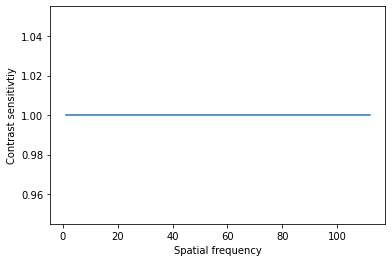

In [62]:
plt.plot(sfs, sensitivities)
plt.xlabel("Spatial frequency")
plt.ylabel("Contrast sensitivity")

# 5. Systematic experiments

Using a linear classifier to probe the internal representation of pretrained networks:
* allows for unifying the psychophysical experiments of biological and artificial systems,
* is not limited to measuring the contrast sensitivity function of a network, and it can be used for other psychophysics.